In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from functools import partial

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from src.config import Config
from src.episode import Episode
from src.episode_dataset import EpisodeRLDataset
from src.rl_data_record import RLDataRecord
from src.policy_factory import PolicyMode, PolicyFactory
from src.reward_model import RewardModel
from src.grpo_trainer import GRPOTrainer
from src.policy_model_utils import load_policy_model, save_policy_model, train_and_plot_policy, inference_and_plot_policy_v2
from src.utils import get_color, normalize_min_max, to_device_collate, top_k_sampling
from src.episode_batch_repeat_sampler import EpisodeBatchRepeatSampler

# Setup
---

In [ ]:
config = Config()
reward_model = RewardModel(config=config)
test_policy = PolicyFactory.create(
    policy_mode=PolicyMode.TRANSFORMER_WITH_LATE_POSITION_FUSION, config=config
)

# Datasets

train_dataset = EpisodeRLDataset(config=config, split="TRAIN")
print(f"train_dataset : {len(train_dataset)}")

test_dataset = EpisodeRLDataset(config=config, split="TEST")
print(f"test_dataset : {len(test_dataset)}")

eval_dataset = EpisodeRLDataset(config=config, split="EVAL")
print(f"eval_dataset : {len(eval_dataset)}")


# DataLoaders
def get_data_loader(
    dataset: EpisodeRLDataset, batch_size: int, group_size: int, repeats: int
):
    batch_repeat_sampler = EpisodeBatchRepeatSampler(
        dataset=dataset,
        batch_size=batch_size,
        group_size=group_size,
        repeats=repeats,
    )
    # print(
    #     f"batch_repeat_sampler: {len(batch_repeat_sampler)},  {list(batch_repeat_sampler)}"
    # )
    # print(
    #     f"batch ids: {[e.episode_id for e in dataset.get_episods(batch_episode_indices=list(batch_repeat_sampler))]}"
    # )

    to_device_collate_configurable = partial(to_device_collate, config.device)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size * group_size,
        sampler=batch_repeat_sampler,
        collate_fn=to_device_collate_configurable,
    )
    print(f"data loader: {dataset.split}, {len(dataloader)}")
    return dataloader


train_dataloader = get_data_loader(
    dataset=train_dataset,
    batch_size=config.train_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

test_dataloader = get_data_loader(
    dataset=test_dataset,
    batch_size=config.test_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

eval_dataloader = get_data_loader(
    dataset=eval_dataset,
    batch_size=config.eval_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

train_dataset : 400000
test_dataset : 80
eval_dataset : 4000
data loader: TRAIN, 7500
data loader: TEST, 75
data loader: EVAL, 75


In [3]:
# for idx, batch_data in enumerate(test_dataloader):
#     batch_episode_indices = batch_data.get("episode_idx")
#     print(
#         f"idx: {idx}, batch_items: {len(batch_episode_indices)}, batch ids: {[e.episode_id for e in test_dataset.get_episods(batch_episode_indices=batch_episode_indices)]}"
#     )

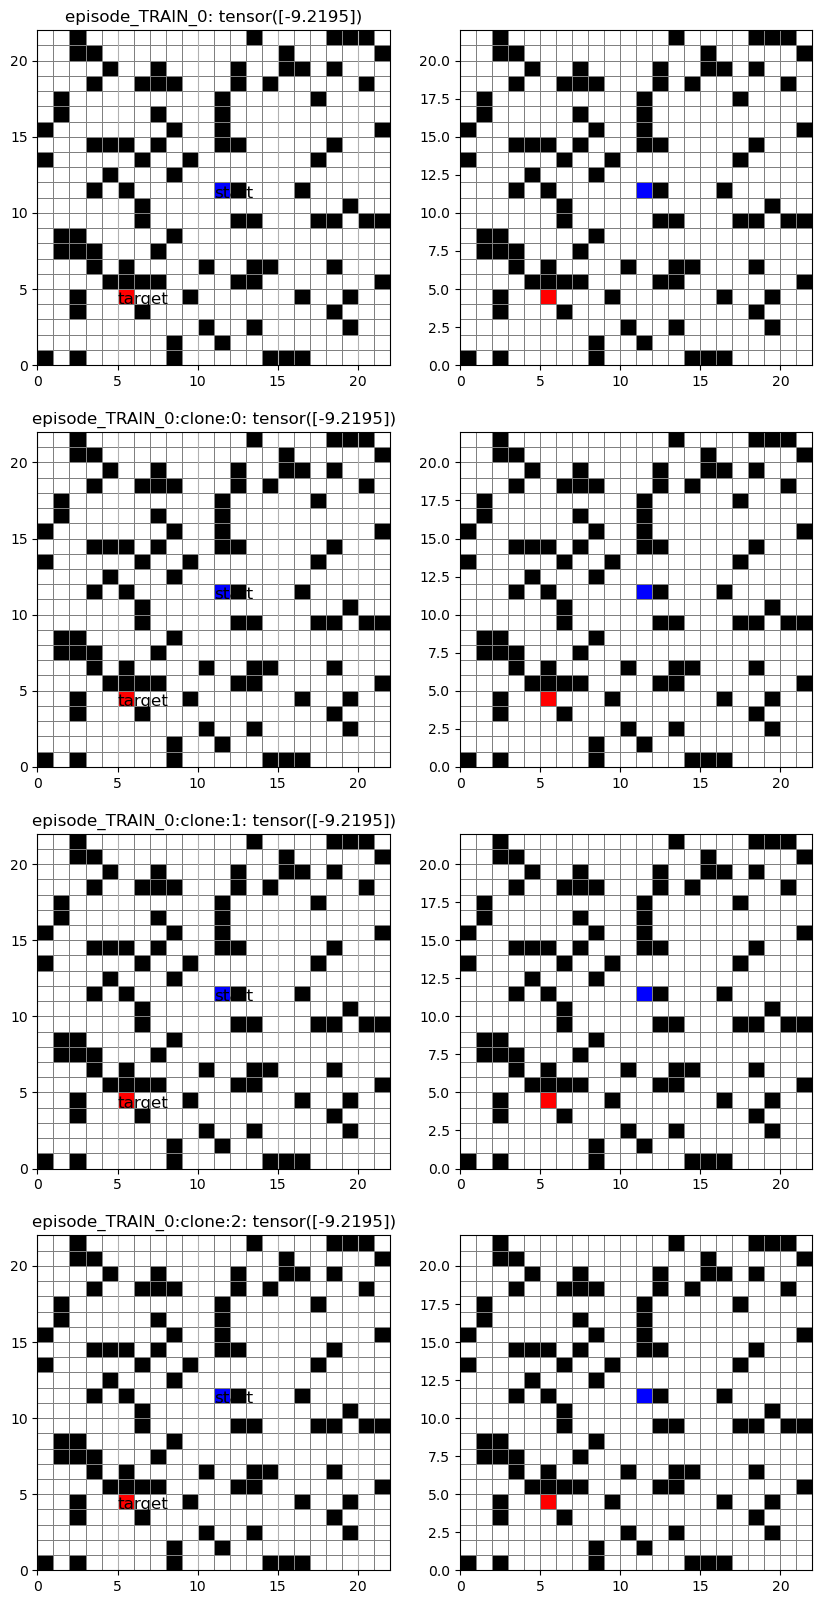

In [4]:
episode_samples = 4
fig, axes = plt.subplots(nrows=episode_samples, ncols=2, figsize=(10, 20))

for eidx in range(episode_samples):
    es = train_dataset.get_episode(eidx)

    es.viz(ax=axes[eidx][0], reward_model=reward_model)

    # Viz fov
    fov = es.fov(center_pos=es.agent.start_state.position())
    # print(f"fov: {fov.size()}, {fov}")
    # print(f"fov: {fov}")
    es.viz_fov(ax=axes[eidx][1])
plt.show()

# Training Loop
---

In [5]:
policy = PolicyFactory.create(
    policy_mode=PolicyMode.TRANSFORMER_WITH_LATE_POSITION_FUSION, config=config
).to(config.device)
reward_model = RewardModel(config=config)
trainer = GRPOTrainer(config=config, policy=policy, reward_model=reward_model)

In [6]:
trainer.policy.img_to_emb.weight.device

device(type='cpu')

TEST:  17%|█▋        | 13/75 [00:00<00:00, 122.77it/s]

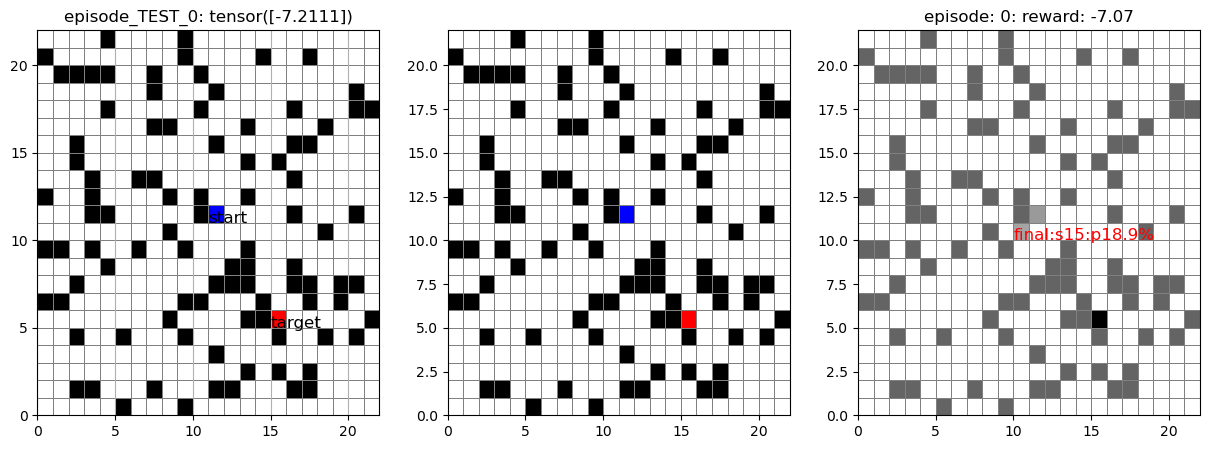

TEST:  35%|███▍      | 26/75 [00:00<00:00, 56.86it/s, split=TEST, batch_idx=14, is_episode_step_done=1, target_episodes=['episode_TEST_0', 'episode_TEST_0:clone:0', 'episode_TEST_0:clone:1', 'episode_TEST_0:clone:2', 'episode_TEST_0:clone:3', 'episode_TEST_0:clone:4', 'episode_TEST_0:clone:5', 'episode_TEST_0:clone:6', 'episode_TEST_1', 'episode_TEST_1:clone:0', 'episode_TEST_1:clone:1', 'episode_TEST_1:clone:2', 'episode_TEST_1:clone:3', 'episode_TEST_1:clone:4', 'episode_TEST_1:clone:5', 'episode_TEST_1:clone:6'], current_batch_episode_idx=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]] 

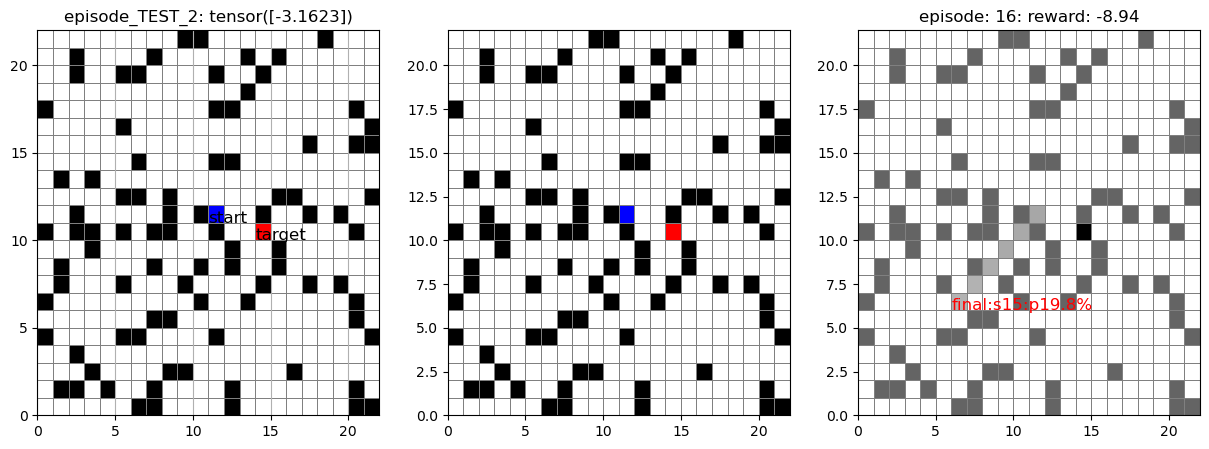

TEST:  45%|████▌     | 34/75 [00:00<00:00, 56.51it/s, split=TEST, batch_idx=29, is_episode_step_done=1, target_episodes=['episode_TEST_2', 'episode_TEST_2:clone:0', 'episode_TEST_2:clone:1', 'episode_TEST_2:clone:2', 'episode_TEST_2:clone:3', 'episode_TEST_2:clone:4', 'episode_TEST_2:clone:5', 'episode_TEST_2:clone:6', 'episode_TEST_3', 'episode_TEST_3:clone:0', 'episode_TEST_3:clone:1', 'episode_TEST_3:clone:2', 'episode_TEST_3:clone:3', 'episode_TEST_3:clone:4', 'episode_TEST_3:clone:5', 'episode_TEST_3:clone:6'], current_batch_episode_idx=[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]

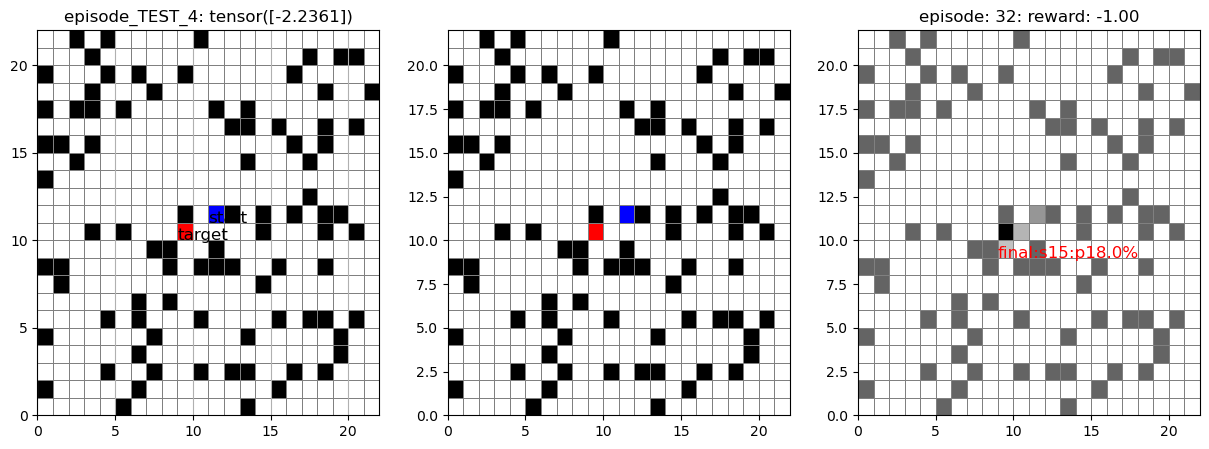

TEST:  77%|███████▋  | 58/75 [00:00<00:00, 76.17it/s, split=TEST, batch_idx=44, is_episode_step_done=1, target_episodes=['episode_TEST_4', 'episode_TEST_4:clone:0', 'episode_TEST_4:clone:1', 'episode_TEST_4:clone:2', 'episode_TEST_4:clone:3', 'episode_TEST_4:clone:4', 'episode_TEST_4:clone:5', 'episode_TEST_4:clone:6', 'episode_TEST_5', 'episode_TEST_5:clone:0', 'episode_TEST_5:clone:1', 'episode_TEST_5:clone:2', 'episode_TEST_5:clone:3', 'episode_TEST_5:clone:4', 'episode_TEST_5:clone:5', 'episode_TEST_5:clone:6'], current_batch_episode_idx=[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]

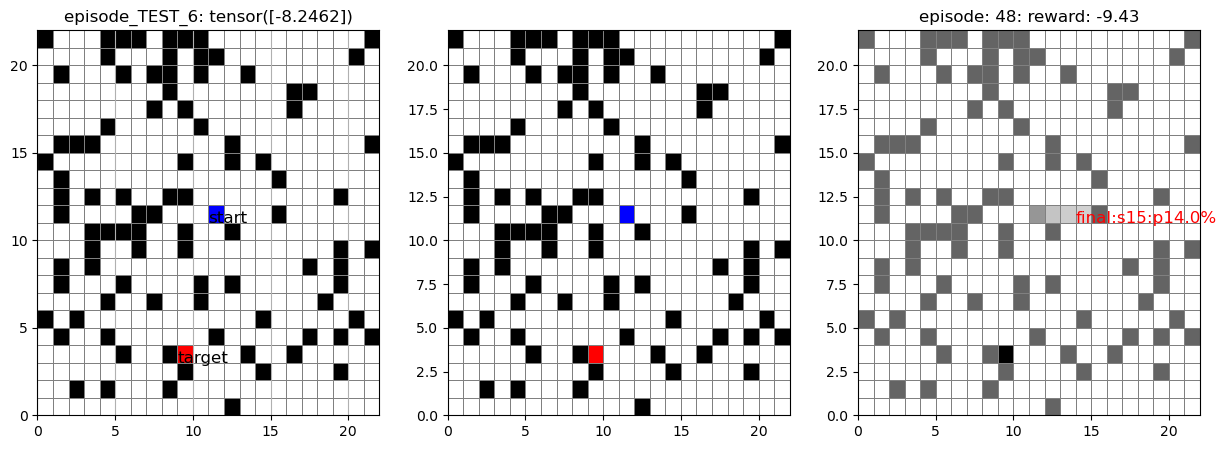

TEST:  89%|████████▉ | 67/75 [00:00<00:00, 69.50it/s, split=TEST, batch_idx=59, is_episode_step_done=1, target_episodes=['episode_TEST_6', 'episode_TEST_6:clone:0', 'episode_TEST_6:clone:1', 'episode_TEST_6:clone:2', 'episode_TEST_6:clone:3', 'episode_TEST_6:clone:4', 'episode_TEST_6:clone:5', 'episode_TEST_6:clone:6', 'episode_TEST_7', 'episode_TEST_7:clone:0', 'episode_TEST_7:clone:1', 'episode_TEST_7:clone:2', 'episode_TEST_7:clone:3', 'episode_TEST_7:clone:4', 'episode_TEST_7:clone:5', 'episode_TEST_7:clone:6'], current_batch_episode_idx=[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]]

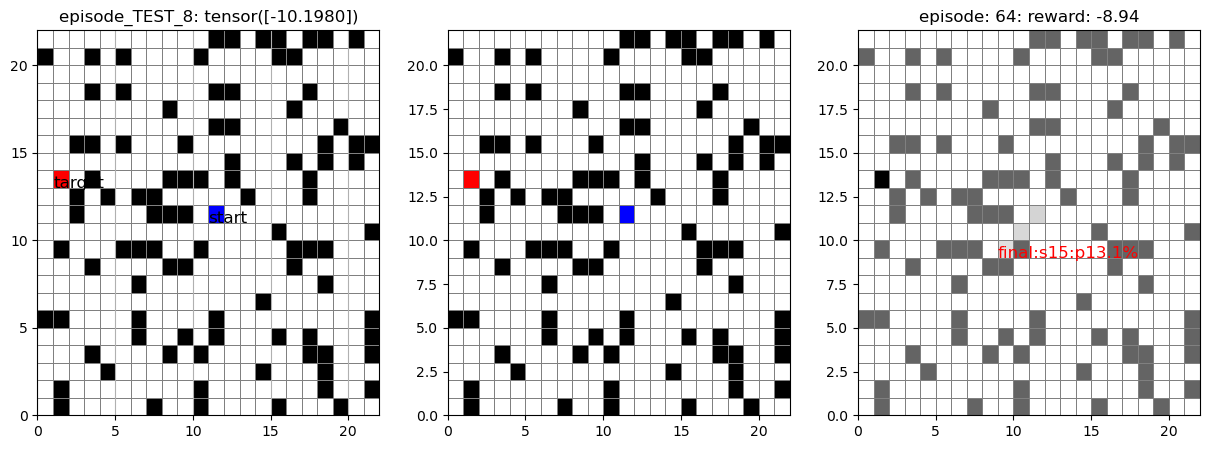

TEST: 100%|██████████| 75/75 [00:01<00:00, 66.23it/s, split=TEST, batch_idx=74, is_episode_step_done=1, target_episodes=['episode_TEST_8', 'episode_TEST_8:clone:0', 'episode_TEST_8:clone:1', 'episode_TEST_8:clone:2', 'episode_TEST_8:clone:3', 'episode_TEST_8:clone:4', 'episode_TEST_8:clone:5', 'episode_TEST_8:clone:6', 'episode_TEST_9', 'episode_TEST_9:clone:0', 'episode_TEST_9:clone:1', 'episode_TEST_9:clone:2', 'episode_TEST_9:clone:3', 'episode_TEST_9:clone:4', 'episode_TEST_9:clone:5', 'episode_TEST_9:clone:6'], current_batch_episode_idx=[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]]


In [7]:
inference_and_plot_policy_v2(
    config=config,
    dataset=test_dataset,
    dataloader=test_dataloader,
    policy=policy,
    reward_model=reward_model,
    top_k=2,
)

In [8]:
# plt.ioff()
trainer.run(train_dataset=train_dataset, eval_dataset=eval_dataset, debug=False)
save_policy_model(policy=policy)

# plt.ion()

train_dataloader: 7500, eval_dataloader: 75


Epoch 1:   0%|          | 0/7500 [00:00<?, ?it/s]/Users/chengbai/ml/cheng_git/rf_agent/src/policy/transformer_model_policy.py:215: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  batch_fov.size(0)
/Users/chengbai/ml/cheng_git/rf_agent/src/policy/transformer_model_policy.py:67: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.tensor(T, dtype=torch.float, device=self.config.device)
/Users/chengbai/ml/cheng_git/rf_agent/src/policy/transformer_model_policy.py:67: UserWarning: To copy construct from a tensor, it is rec

model_path: rf_model_policy_20250606111428.pt
Save policy model to: rf_model_policy_20250606111428.pt


# Evaluate the Model
----

TEST:  13%|█▎        | 10/75 [00:00<00:00, 93.46it/s]

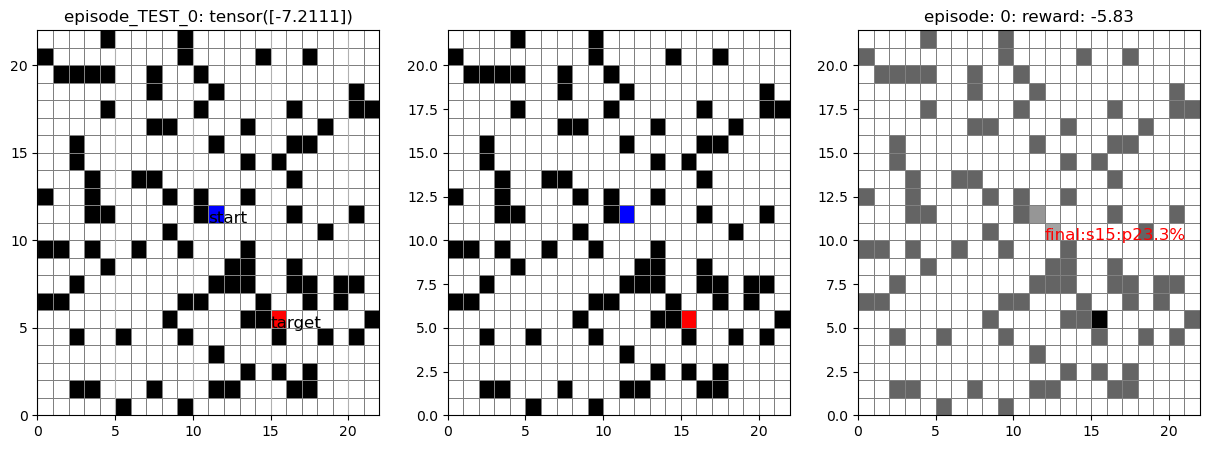

TEST:  27%|██▋       | 20/75 [00:00<00:00, 64.75it/s, split=TEST, batch_idx=14, is_episode_step_done=1, target_episodes=['episode_TEST_0', 'episode_TEST_0:clone:0', 'episode_TEST_0:clone:1', 'episode_TEST_0:clone:2', 'episode_TEST_0:clone:3', 'episode_TEST_0:clone:4', 'episode_TEST_0:clone:5', 'episode_TEST_0:clone:6', 'episode_TEST_1', 'episode_TEST_1:clone:0', 'episode_TEST_1:clone:1', 'episode_TEST_1:clone:2', 'episode_TEST_1:clone:3', 'episode_TEST_1:clone:4', 'episode_TEST_1:clone:5', 'episode_TEST_1:clone:6'], current_batch_episode_idx=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]

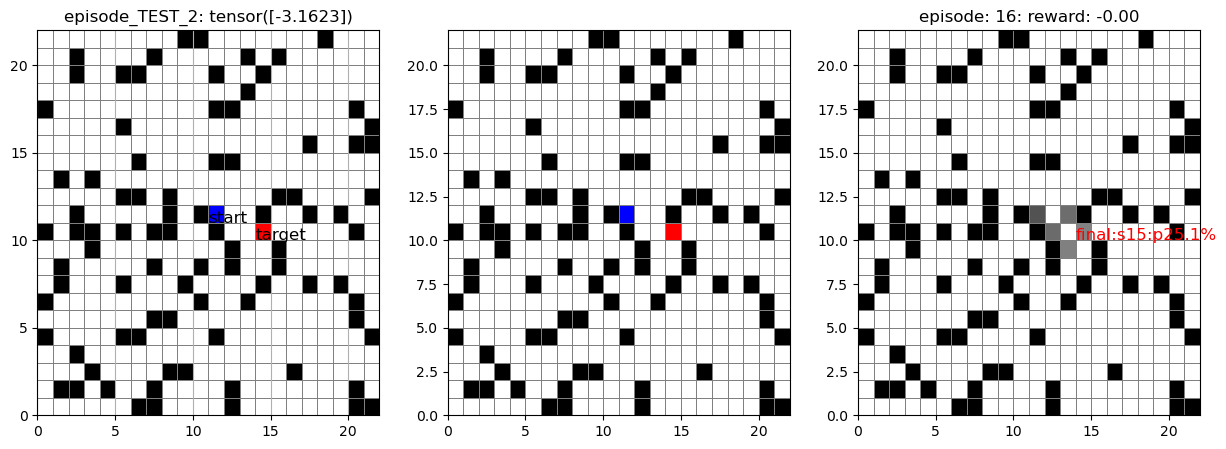

TEST:  55%|█████▍    | 41/75 [00:00<00:00, 71.73it/s, split=TEST, batch_idx=29, is_episode_step_done=1, target_episodes=['episode_TEST_2', 'episode_TEST_2:clone:0', 'episode_TEST_2:clone:1', 'episode_TEST_2:clone:2', 'episode_TEST_2:clone:3', 'episode_TEST_2:clone:4', 'episode_TEST_2:clone:5', 'episode_TEST_2:clone:6', 'episode_TEST_3', 'episode_TEST_3:clone:0', 'episode_TEST_3:clone:1', 'episode_TEST_3:clone:2', 'episode_TEST_3:clone:3', 'episode_TEST_3:clone:4', 'episode_TEST_3:clone:5', 'episode_TEST_3:clone:6'], current_batch_episode_idx=[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]

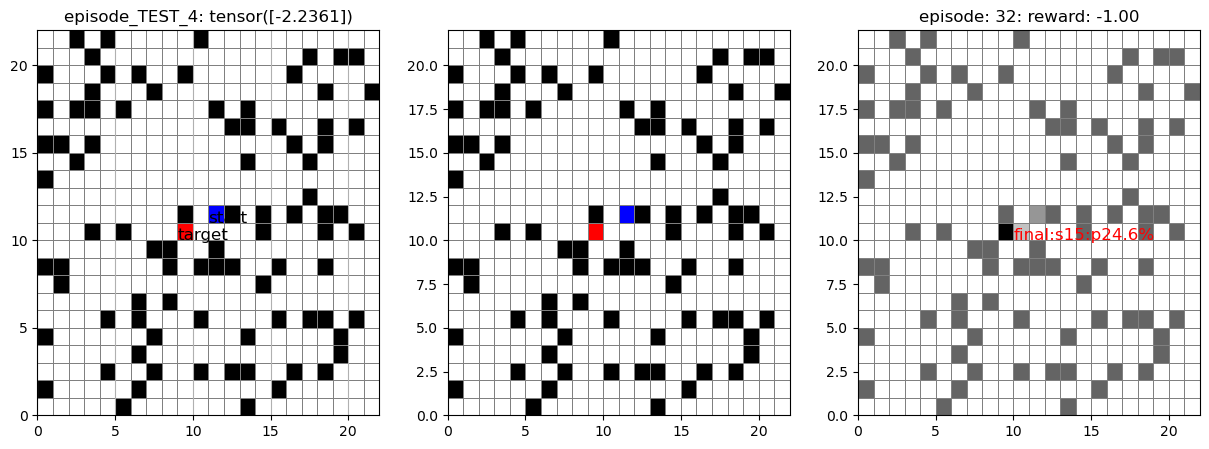

TEST:  65%|██████▌   | 49/75 [00:00<00:00, 63.32it/s, split=TEST, batch_idx=44, is_episode_step_done=1, target_episodes=['episode_TEST_4', 'episode_TEST_4:clone:0', 'episode_TEST_4:clone:1', 'episode_TEST_4:clone:2', 'episode_TEST_4:clone:3', 'episode_TEST_4:clone:4', 'episode_TEST_4:clone:5', 'episode_TEST_4:clone:6', 'episode_TEST_5', 'episode_TEST_5:clone:0', 'episode_TEST_5:clone:1', 'episode_TEST_5:clone:2', 'episode_TEST_5:clone:3', 'episode_TEST_5:clone:4', 'episode_TEST_5:clone:5', 'episode_TEST_5:clone:6'], current_batch_episode_idx=[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]

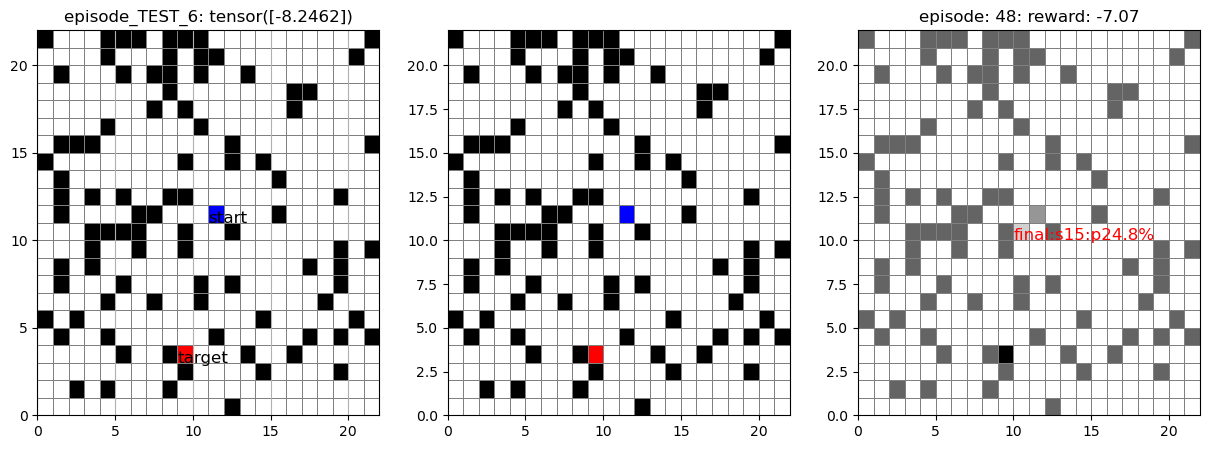

TEST:  95%|█████████▍| 71/75 [00:01<00:00, 71.42it/s, split=TEST, batch_idx=59, is_episode_step_done=1, target_episodes=['episode_TEST_6', 'episode_TEST_6:clone:0', 'episode_TEST_6:clone:1', 'episode_TEST_6:clone:2', 'episode_TEST_6:clone:3', 'episode_TEST_6:clone:4', 'episode_TEST_6:clone:5', 'episode_TEST_6:clone:6', 'episode_TEST_7', 'episode_TEST_7:clone:0', 'episode_TEST_7:clone:1', 'episode_TEST_7:clone:2', 'episode_TEST_7:clone:3', 'episode_TEST_7:clone:4', 'episode_TEST_7:clone:5', 'episode_TEST_7:clone:6'], current_batch_episode_idx=[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]]

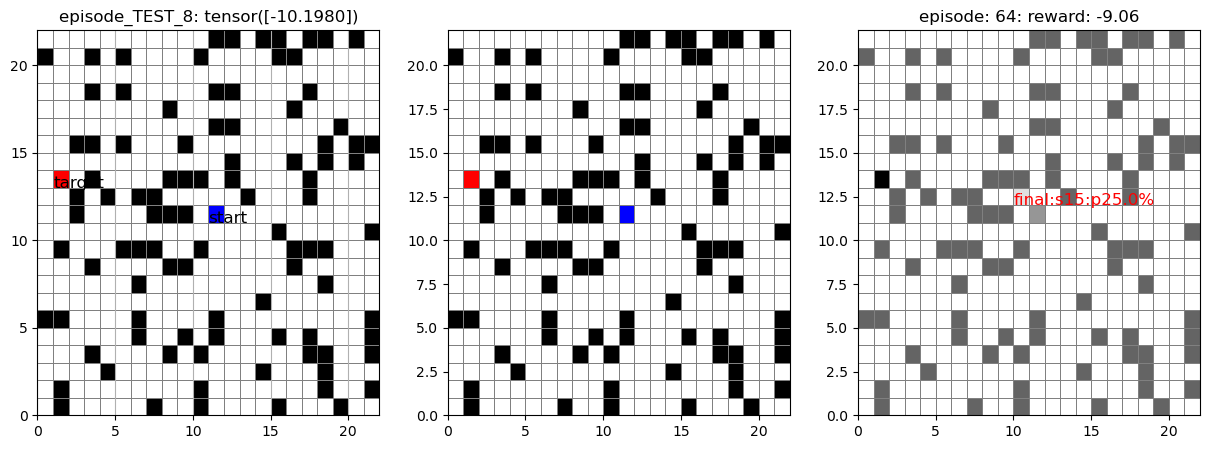

TEST: 100%|██████████| 75/75 [00:01<00:00, 64.23it/s, split=TEST, batch_idx=74, is_episode_step_done=1, target_episodes=['episode_TEST_8', 'episode_TEST_8:clone:0', 'episode_TEST_8:clone:1', 'episode_TEST_8:clone:2', 'episode_TEST_8:clone:3', 'episode_TEST_8:clone:4', 'episode_TEST_8:clone:5', 'episode_TEST_8:clone:6', 'episode_TEST_9', 'episode_TEST_9:clone:0', 'episode_TEST_9:clone:1', 'episode_TEST_9:clone:2', 'episode_TEST_9:clone:3', 'episode_TEST_9:clone:4', 'episode_TEST_9:clone:5', 'episode_TEST_9:clone:6'], current_batch_episode_idx=[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]]


In [9]:
inference_and_plot_policy_v2(
    config=config,
    dataset=test_dataset,
    dataloader=test_dataloader,
    policy=policy,
    reward_model=reward_model,
    top_k=1,
)

TEST:  13%|█▎        | 10/75 [00:00<00:00, 100.00it/s]

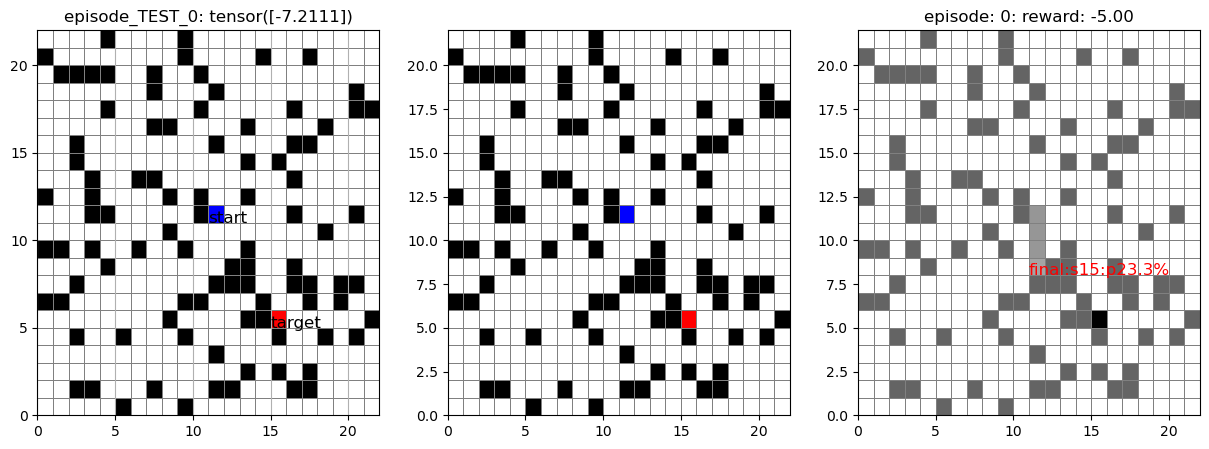

TEST:  27%|██▋       | 20/75 [00:00<00:00, 67.67it/s, split=TEST, batch_idx=14, is_episode_step_done=1, target_episodes=['episode_TEST_0', 'episode_TEST_0:clone:0', 'episode_TEST_0:clone:1', 'episode_TEST_0:clone:2', 'episode_TEST_0:clone:3', 'episode_TEST_0:clone:4', 'episode_TEST_0:clone:5', 'episode_TEST_0:clone:6', 'episode_TEST_1', 'episode_TEST_1:clone:0', 'episode_TEST_1:clone:1', 'episode_TEST_1:clone:2', 'episode_TEST_1:clone:3', 'episode_TEST_1:clone:4', 'episode_TEST_1:clone:5', 'episode_TEST_1:clone:6'], current_batch_episode_idx=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]] 

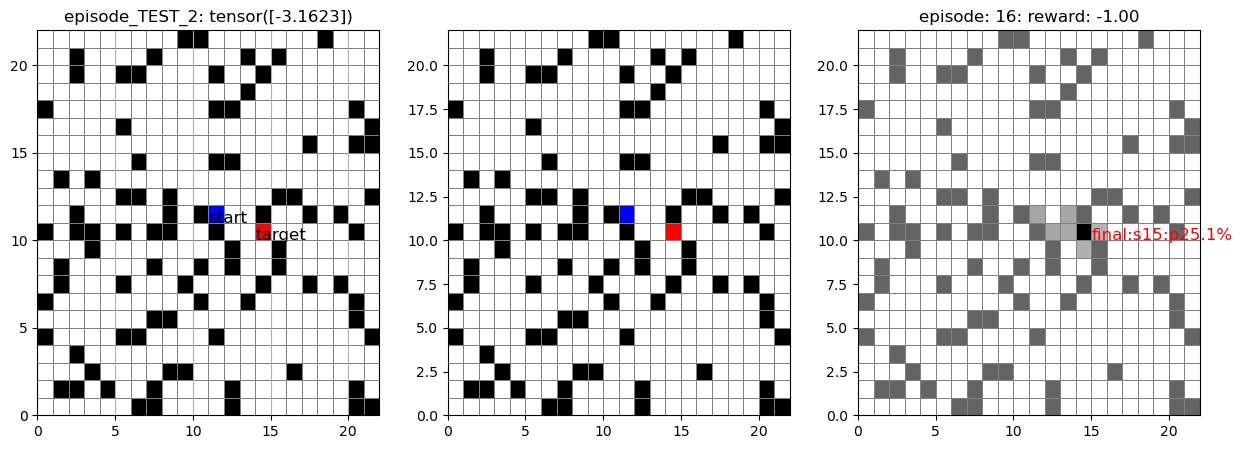

TEST:  56%|█████▌    | 42/75 [00:00<00:00, 78.22it/s, split=TEST, batch_idx=29, is_episode_step_done=1, target_episodes=['episode_TEST_2', 'episode_TEST_2:clone:0', 'episode_TEST_2:clone:1', 'episode_TEST_2:clone:2', 'episode_TEST_2:clone:3', 'episode_TEST_2:clone:4', 'episode_TEST_2:clone:5', 'episode_TEST_2:clone:6', 'episode_TEST_3', 'episode_TEST_3:clone:0', 'episode_TEST_3:clone:1', 'episode_TEST_3:clone:2', 'episode_TEST_3:clone:3', 'episode_TEST_3:clone:4', 'episode_TEST_3:clone:5', 'episode_TEST_3:clone:6'], current_batch_episode_idx=[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]

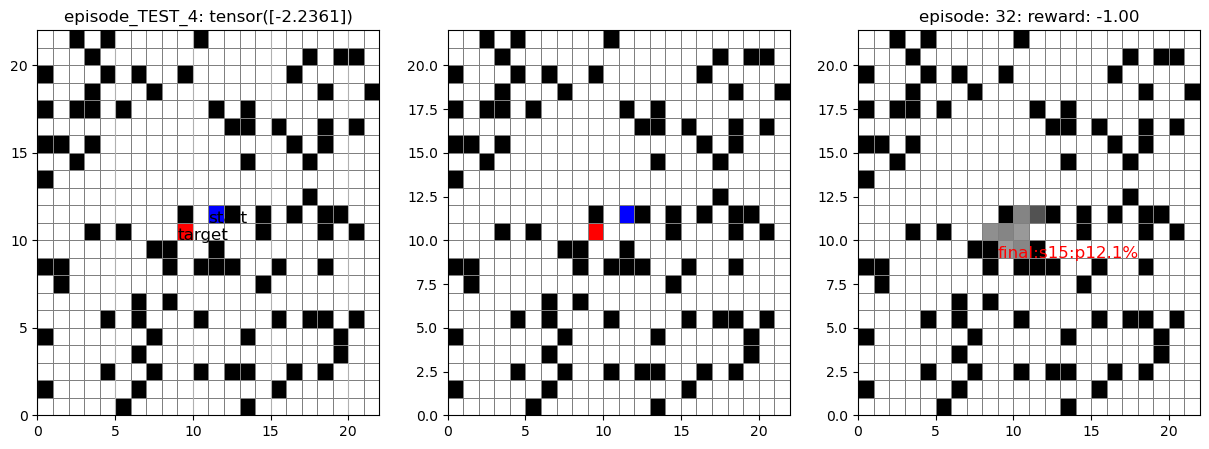

TEST:  68%|██████▊   | 51/75 [00:00<00:00, 69.48it/s, split=TEST, batch_idx=44, is_episode_step_done=1, target_episodes=['episode_TEST_4', 'episode_TEST_4:clone:0', 'episode_TEST_4:clone:1', 'episode_TEST_4:clone:2', 'episode_TEST_4:clone:3', 'episode_TEST_4:clone:4', 'episode_TEST_4:clone:5', 'episode_TEST_4:clone:6', 'episode_TEST_5', 'episode_TEST_5:clone:0', 'episode_TEST_5:clone:1', 'episode_TEST_5:clone:2', 'episode_TEST_5:clone:3', 'episode_TEST_5:clone:4', 'episode_TEST_5:clone:5', 'episode_TEST_5:clone:6'], current_batch_episode_idx=[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]

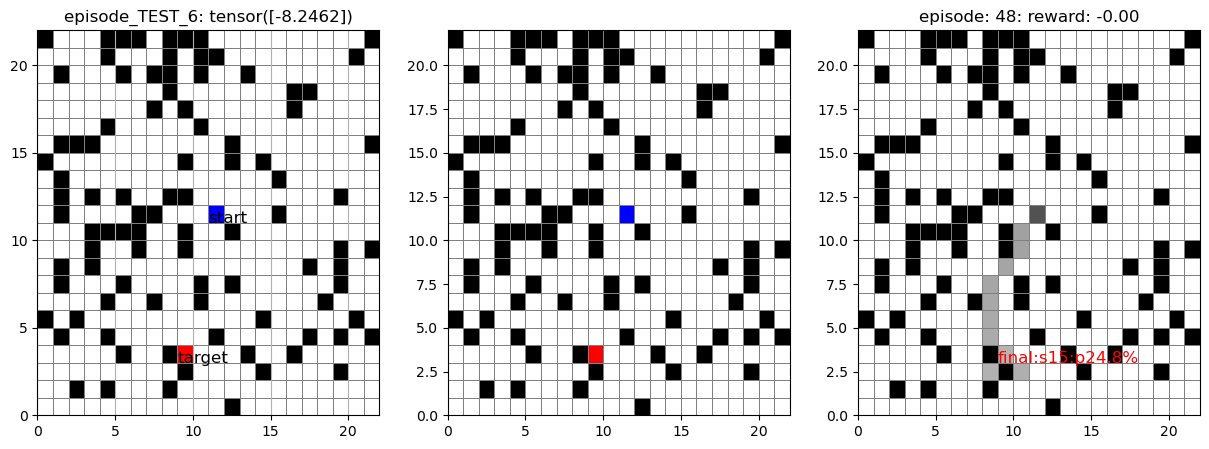

TEST:  96%|█████████▌| 72/75 [00:00<00:00, 76.75it/s, split=TEST, batch_idx=59, is_episode_step_done=1, target_episodes=['episode_TEST_6', 'episode_TEST_6:clone:0', 'episode_TEST_6:clone:1', 'episode_TEST_6:clone:2', 'episode_TEST_6:clone:3', 'episode_TEST_6:clone:4', 'episode_TEST_6:clone:5', 'episode_TEST_6:clone:6', 'episode_TEST_7', 'episode_TEST_7:clone:0', 'episode_TEST_7:clone:1', 'episode_TEST_7:clone:2', 'episode_TEST_7:clone:3', 'episode_TEST_7:clone:4', 'episode_TEST_7:clone:5', 'episode_TEST_7:clone:6'], current_batch_episode_idx=[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]]

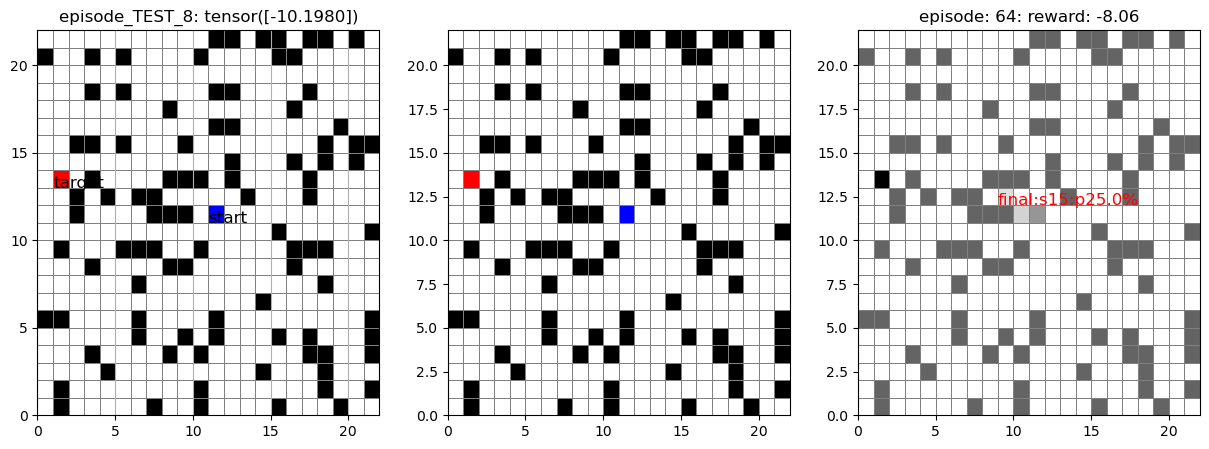

TEST: 100%|██████████| 75/75 [00:01<00:00, 68.66it/s, split=TEST, batch_idx=74, is_episode_step_done=1, target_episodes=['episode_TEST_8', 'episode_TEST_8:clone:0', 'episode_TEST_8:clone:1', 'episode_TEST_8:clone:2', 'episode_TEST_8:clone:3', 'episode_TEST_8:clone:4', 'episode_TEST_8:clone:5', 'episode_TEST_8:clone:6', 'episode_TEST_9', 'episode_TEST_9:clone:0', 'episode_TEST_9:clone:1', 'episode_TEST_9:clone:2', 'episode_TEST_9:clone:3', 'episode_TEST_9:clone:4', 'episode_TEST_9:clone:5', 'episode_TEST_9:clone:6'], current_batch_episode_idx=[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]]


In [10]:
inference_and_plot_policy_v2(
    config=config,
    dataset=test_dataset,
    dataloader=test_dataloader,
    policy=policy,
    reward_model=reward_model,
    top_k=2,
)

In [11]:
# policy_model_path = (
#     "/Users/chengbai/ml/cheng_git/rf_agent/rf_model_policy_20250510230738_base.pt"
# )
# trained_policy = load_policy_model(config=config, policy_model_path=policy_model_path)
# assert trained_policy is not None

# episode = inference_and_plot_policy(
#     policy=trained_policy, config=config, reward_model=reward_model, steps=5, debug=True
# )